## Vector Autoregression

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Dicionario dos dados
#For this article let’s use the time series used in Yash P Mehra’s 1994 article: “Wage Growth and the Inflation Process: An Empirical Approach”.

#1. rgnp  : Real GNP.
#2. pgnp  : Potential real GNP.
#3. ulc   : Unit labor cost.
#4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
#5. gdf   : Fixed weight GNP deflator.
#6. gdfim : Fixed weight import deflator.
#7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
#8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

### Import the datasets

In [4]:
df = pd.read_csv('Raotbl6.csv', parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.70,3971.90,179.60,131.50,124.90,106.20,123.50,92.80
1988-10-01,4069.40,3995.80,181.30,133.30,126.20,107.30,124.90,92.90
1989-01-01,4106.80,4019.90,184.10,134.80,127.70,109.50,126.60,94.00
1989-04-01,4132.50,4044.10,186.10,134.80,129.30,111.10,129.00,100.60
1989-07-01,4162.90,4068.40,187.40,137.20,130.20,109.80,129.90,98.20


### Visualize the Time Series

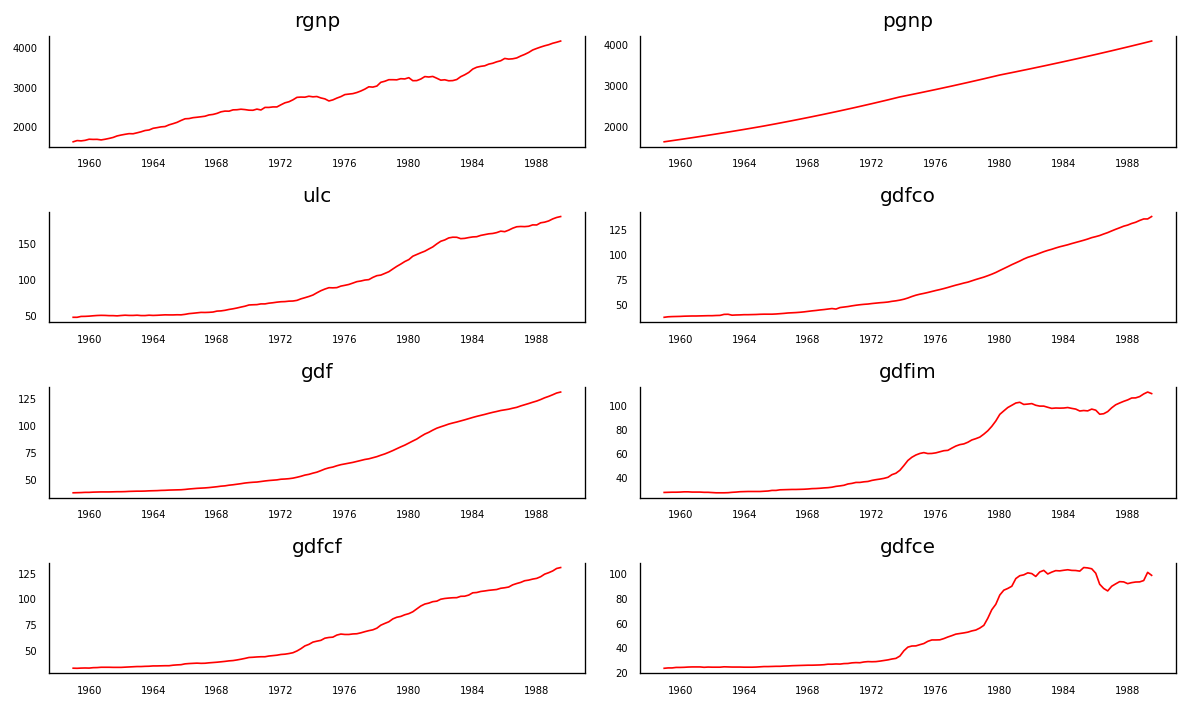

In [5]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Testing Causation using Granger’s Causality Test

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.00,0.00,0.00,0.02,0.00,0.06,0.00,0.01
pgnp_y,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
ulc_y,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
gdfco_y,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
gdf_y,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
gdfim_y,0.00,0.01,0.00,0.01,0.00,1.00,0.00,0.00
gdfcf_y,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
gdfce_y,0.00,0.05,0.00,0.00,0.00,0.00,0.00,1.00


### Cointegration Test

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


### Split the Series into Training and Testing Data

In [9]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


### Check for Stationarity and Make the Time Series Stationary

In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [11]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [12]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [13]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [14]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [16]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1311
 No. Lags Chosen       = 9
 Critical value 1%     = -3.494
 Critical value 5%     = -2.889
 Critical value 10%    = -2.582
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0577
 No. Lags Chosen       = 4
 Critical value 1%     = -3.491
 Critical value 5%     = -2.888
 Critical value 10%    = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

###  How to Select the Order (P) of VAR model

In [17]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  3.7008979597918072
BIC :  5.419464161897494
FPE :  40.58764941354199
HQIC:  4.398455407198519 

Lag Order = 2
AIC :  2.037744388074596
BIC :  5.301981133527679
FPE :  7.812072029796984
HQIC:  3.3625151361224166 

Lag Order = 3
AIC :  1.2710988906021279
BIC :  6.098333967969102
FPE :  3.7833537328388727
HQIC:  3.229940631319874 

Lag Order = 4
AIC :  0.9751521339276019
BIC :  7.383042330551753
FPE :  3.0622610222354902
HQIC:  3.575036925061407 

Lag Order = 5
AIC :  0.38434143030663037
BIC :  8.390881124274607
FPE :  1.9689762758884988
HQIC:  3.6323579322851245 

Lag Order = 6
AIC :  -0.5465657973543134
BIC :  9.076964233469571
FPE :  0.9904500727205936
HQIC:  3.3567899466566935 

Lag Order = 7
AIC :  -1.1543945391632615
BIC :  10.104822289244899
FPE :  0.790243259085502
HQIC:  3.411629146368698 

Lag Order = 8
AIC :  -2.721193016746108
BIC :  10.192772150889025
FPE :  0.2969799009786333
HQIC:  2.514950803154335 

Lag Order = 9
AIC :  -3.8113111431846676
BIC :  10.7

In [ ]:
### Alternative methods
x = model.select_order(maxlags=12)
x.summary()

### Train the VAR Model of Selected Order(p)

In [18]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, Oct, 2022
Time:                     17:17:26
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    7.38304
Nobs:                     112.000    HQIC:                   3.57504
Log likelihood:          -1061.98    FPE:                    3.06226
AIC:                     0.975152    Det(Omega_mle):        0.388010
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.355274         2.889014            0.123           0.902
L1.rgnp         -1.221048         0.154867           -7.884           0.000
L1.pgnp         -1.923334         5.310903           -0.362           0.717
L1.ul

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [20]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): 
        return str(val).ljust(length)


out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rgnp   : 2.17
pgnp   : 2.12
ulc    : 2.0
gdfco  : 2.24
gdf    : 2.08
gdfim  : 1.97
gdfcf  : 2.17
gdfce  : 2.19


### How to Forecast VAR model using statsmodels

In [21]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)
 #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 4.70000000e+00,  4.54747351e-13,  7.00000000e-01,
         2.00000000e-01,  1.00000000e-01,  9.00000000e-01,
         1.40000000e+00, -1.90000000e+00],
       [-3.71000000e+01,  1.00000000e-01, -3.40000000e+00,
        -6.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        -7.00000000e-01,  8.00000000e-01],
       [ 2.03000000e+01, -1.00000000e-01,  5.10000000e+00,
         1.00000000e+00,  4.00000000e-01,  6.00000000e-01,
         1.20000000e+00,  3.40000000e+00],
       [-6.00000000e-01,  1.00000000e-01, -5.20000000e+00,
        -9.00000000e-01, -1.00000000e-01, -1.90000000e+00,
         1.42108547e-14, -2.50000000e+00]])

In [22]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,77.32,1.19,2.20,0.32,-0.14,0.46,-1.22,-0.52
1989-01-01,-113.83,-1.39,0.07,0.19,0.24,1.75,1.36,3.25
1989-04-01,88.26,0.79,-0.65,-0.48,-0.67,-1.36,-1.68,-4.06
1989-07-01,-80.60,-0.66,1.54,0.46,0.85,-0.73,1.53,1.89


###  Invert the transformation to get the real forecast

In [27]:
def invert_transformation(df_train, df_forecast, second_diff=False):

    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [29]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast', 'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4152.02,3996.89,182.70,133.02,126.36,106.76,124.78,92.78
1989-01-01,4147.52,4020.48,185.86,134.74,128.06,109.07,127.41,96.01
1989-04-01,4231.28,4044.87,188.38,135.98,129.09,110.03,128.36,95.19
1989-07-01,4234.43,4068.59,192.44,137.68,130.96,110.25,130.84,96.26


### Plot of Forecast vs Actuals

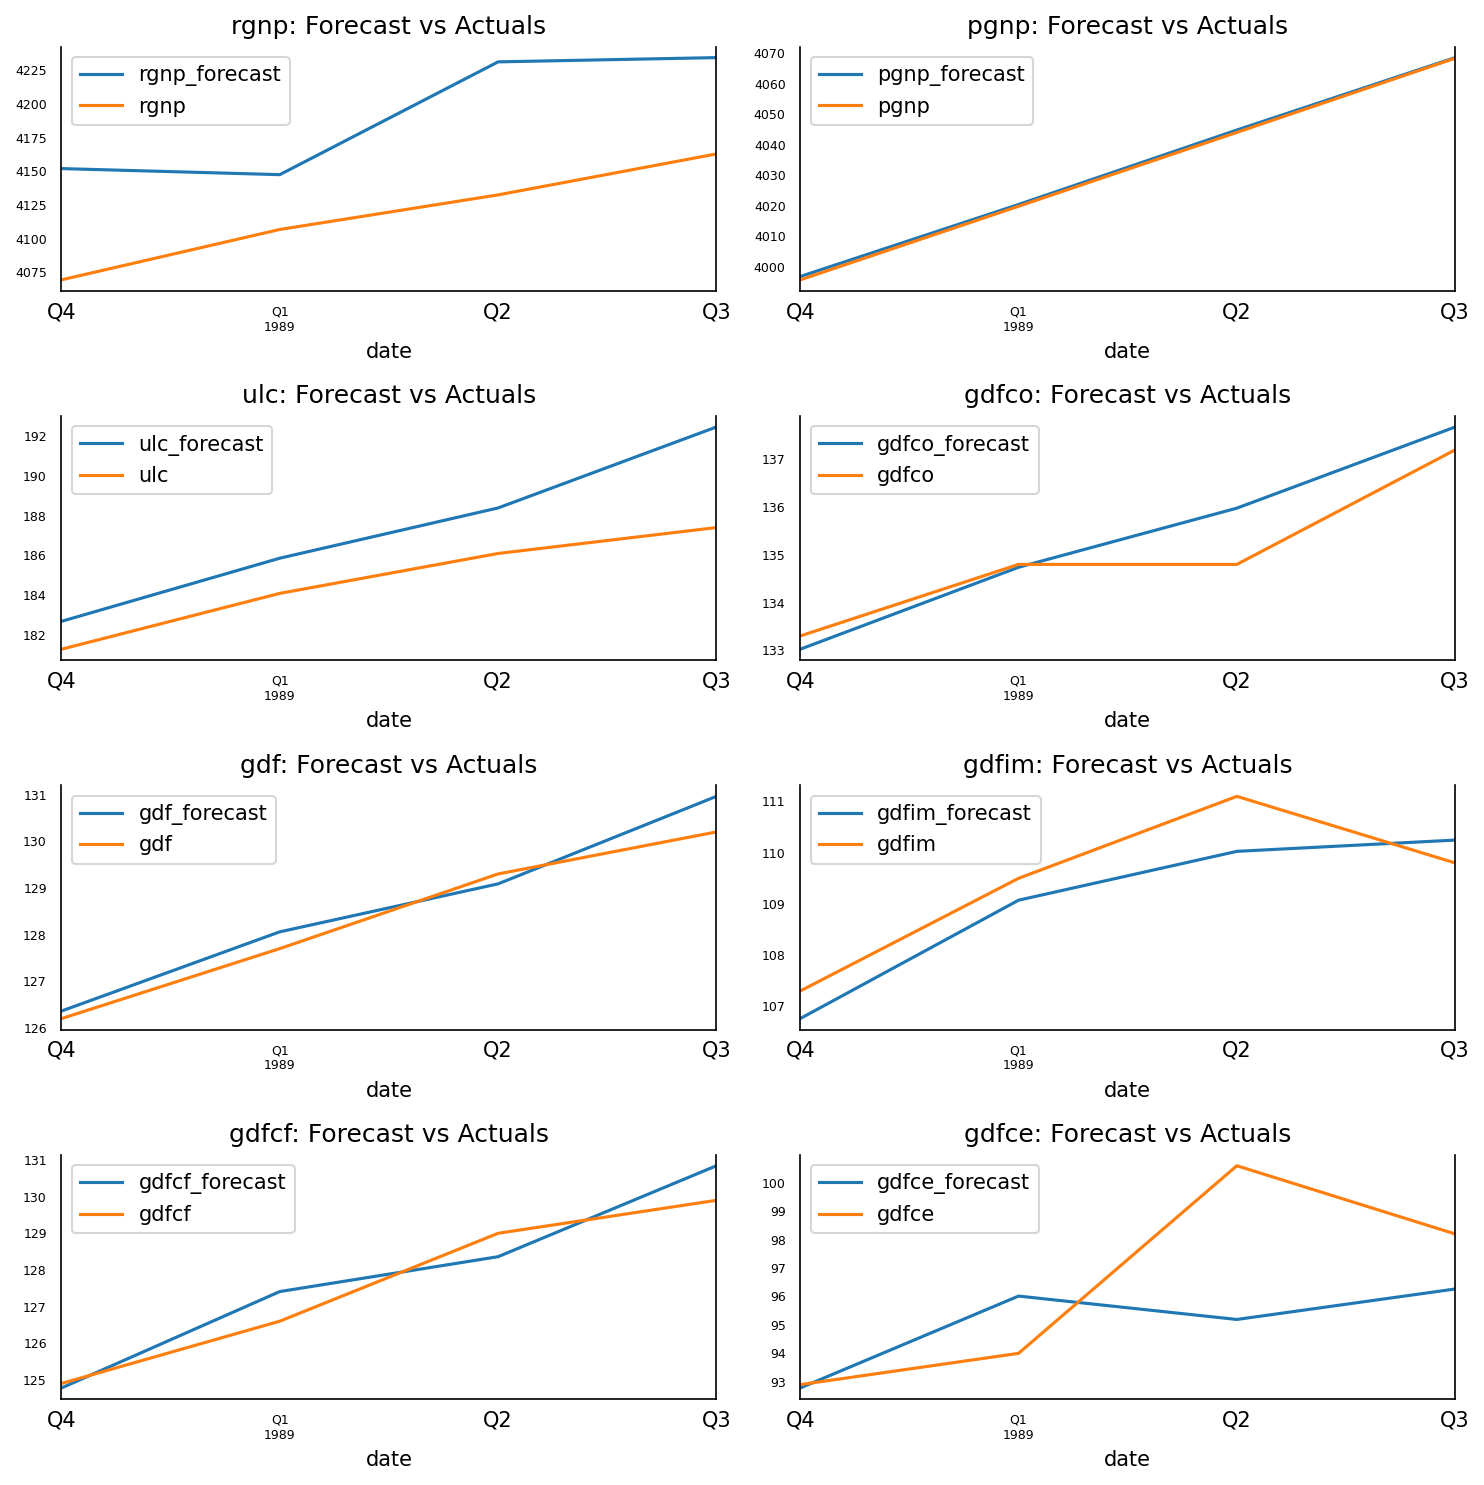

In [31]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

### Evaluate the Forecasts

In [32]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual)/actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5 # RMSE
    corr = np.corrcoef(forecast, actual)[0,1] # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs) # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [34]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0178
me     :  73.4113
mae    :  73.4113
mpe    :  0.0178
rmse   :  76.4158
corr   :  0.8608
minmax :  0.0175

Forecast Accuracy of: pgnp
mape   :  0.0002
me     :  0.6578
mae    :  0.6578
mpe    :  0.0002
rmse   :  0.7331
corr   :  1.0
minmax :  0.0002

Forecast Accuracy of: ulc
mape   :  0.0141
me     :  2.6212
mae    :  2.6212
mpe    :  0.0141
rmse   :  2.9869
corr   :  0.9725
minmax :  0.0139

Forecast Accuracy of: gdfco
mape   :  0.0037
me     :  0.3302
mae    :  0.4992
mpe    :  0.0024
rmse   :  0.6521
corr   :  0.9534
minmax :  0.0037

Forecast Accuracy of: gdf
mape   :  0.0029
me     :  0.2678
mae    :  0.374
mpe    :  0.0021
rmse   :  0.4421
corr   :  0.9794
minmax :  0.0029

Forecast Accuracy of: gdfim
mape   :  0.0057
me     :  -0.3982
mae    :  0.6214
mpe    :  -0.0036
rmse   :  0.6753
corr   :  0.9212
minmax :  0.0057

Forecast Accuracy of: gdfcf
mape   :  0.0049
me     :  0.248
mae    :  0.6289
mpe    :  0.0019
rmse   :  0.7018
corr 